# Recitation 8: Logistic Regression

This recitation will be due with the homework on Monday April 12 at 11:59pm.

## Case Background
In this lab, we continue the analysis of the metal casting problem from the previous recitation. Recall that, as part of a longer
manufacturing process, a factory needs to cast a large number of rectangular metallic blocks.
The blocks are manufactured using a mold, consisting of the main cavity, a cup through
which the molten metal is poured, and two risers for cooling. The size and shape of the
pouring cup and risers affect how quickly the metal can be poured into the mold, how
quickly it cools, and whether it sets correctly.

## Objective
The factory needs to cast batches of 100 blocks of size 4.5×4.5×7 inches. The
current casting approach is conservative – it takes a long time to pour, but the blocks
always set correctly and are usable. Your goal is to achieve a significant reduction in
average casting time while still ensuring that most blocks are usable.



## Variables describing the mold

The following nine variables describe the shape of the mold:
* Riser Height
* Riser Diameter
* Riser 1 Position
* Riser 2 Position
* Gate Diameter
* Cup Height
* Sprue Height
* Sprue Diameter Bottom
* Sprue Diameter Top
Together we call these the "mold variables".

We will vary these parameters to choose a new shape for the mold to reduce average casting time while ensuring most blocks are usable.

## Data

To obtain data on how the mold variables affect pouring and cooling, a batch of 100 blocks are poured while randomly varying the nine mold variables around their baseline values. The data is available in castdata.csv. This is the same file as the previous recitation. As before, the first nine columns are the mold-variables listed above. The 10th column is `BatchTime` (how long the molten metal took to cool inside the mold). The 11th column is `Feasible`. `Feasible` is 1 if the block that came out of the mold was usable and 0 if it wasn't.

## ASSIGNMENT

This lab project will guide you through the analysis. First, we must import castdata.csv into the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
df = pd.read_csv('castdata.csv')
df.head() # view the data

,GateDiam,CupHeight,SprueHeight,RiserDiam,SprueDiamBot,SprueDiamTop,RiserHeight,Riser1Pos,Riser2Pos,BatchTime,Feasible
0,0.500000,5.000000,10.000000,7.000000,0.500000,0.750000,5.000000,3.500000,5.000000,3031.292318,1
1,0.318317,5.604768,10.148839,6.745247,0.635632,0.889822,5.318354,3.168774,5.233322,3042.417820,0
2,0.353834,5.846289,9.528183,7.345273,0.642489,1.005683,4.836570,3.265961,5.482437,3050.300487,1
3,0.596163,4.280124,10.887751,6.952856,0.317180,0.589558,5.492964,4.029533,4.719791,3034.202547,1
4,0.484338,5.205026,11.003688,7.254450,0.531424,0.595769,4.897376,4.011947,4.822747,3033.046509,1


Now we compare the distributions of the predictors (the mold variables) among two subsets of the data: those with Feasible = 0 and those with Feasible = 1. 

Before doing this, we first normalize each of the predictors by subtracting off its mean value and dividing by its standard deviation. This puts all of the predictors on the same scale, so that we can plot them together. (The boxplot() function we use below doesn't allow multiple y axes, so if we didn't do this then we would mostly see that the different predictors have different mean values, which wouldn't be very informative.) Also, by subtracting off the mean value and dividing by their standard deviation, we can more easily see how changes in these values, within the range evaluated in our data, affect feasibility.

In [2]:
normalized = df.copy()
predictors = np.delete(normalized.columns.values,[9,10]) # All columns except Feasible and BatchTime are predictors
for i in predictors:
    # Normalize all predictors
    normalized[i]=(normalized[i]-normalized[i].mean())/normalized[i].std()
    
normalized.head()

,GateDiam,CupHeight,SprueHeight,RiserDiam,SprueDiamBot,SprueDiamTop,RiserHeight,Riser1Pos,Riser2Pos,BatchTime,Feasible
0,0.093566,-0.038859,-0.112868,0.037250,-0.051764,-0.078771,0.091616,0.024610,0.149696,3031.292318,1
1,-1.161374,1.499244,0.155546,-0.428747,1.055643,0.698712,0.818235,-0.855144,0.653394,3042.417820,0
2,-0.916050,2.113506,-0.963736,0.668825,1.111626,1.342958,-0.281401,-0.597010,1.191190,3050.300487,1
3,0.757796,-1.869717,1.488091,-0.048987,-1.544448,-0.970910,1.216770,1.431078,-0.455224,3034.202547,1
4,-0.014619,0.482582,1.697170,0.502691,0.204806,-0.936376,-0.142616,1.384370,-0.232962,3033.046509,1


We now make a boxplot showing the distribution of each predictor in the two subsets of the data (those with Feasible=0 and Feasible=1).

If you haven't used boxplots before, here is how they work. A boxplot uses a box to visualize a collection of observations. In the center of the box is a green line. The height of this line is the median of the observations. The height of the top of the box is the 75% quantile (the number such that 75% of the observations are below it). The height of the bottom of the box is the 25% quantile. There are lines coming out of the box (called
“whiskers”) that represent the range of values over which most of the data falls. There may be a few circles above and below the whiskers, which are data that fall outside of this range. These points are called “outliers”.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016A2D54EE48>,
      dtype=object)

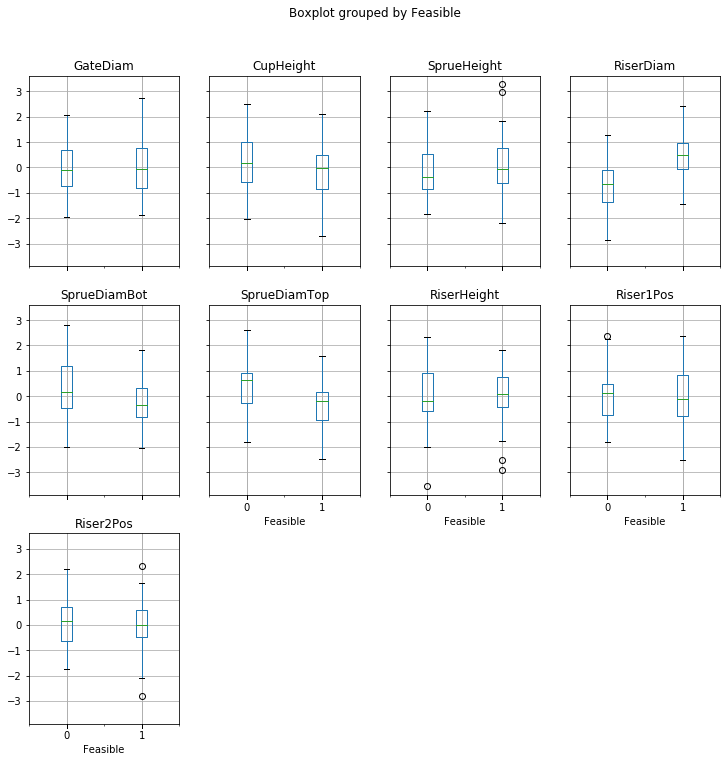

In [3]:
normalized.boxplot(column = predictors.tolist(), by = 'Feasible', layout=(3,4), figsize=(12,12))
# layout=(2,2) configures how the plots will be outputted into the console
# for more info on boxplot() head to the link:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html

Based on the boxplots above, we can get a rough sense for which variables have the biggest effect on feasibility. To do this, we can look at the boxes for a predictor to see how the quantiles (25%, 50%, 75%) differ between the two subsets: Feasible = 1 and Feasible = 0. If each of these quantiles is similar, so that the two boxes have the same top, green line, and bottom, then the predictor probably doesn't have much effect on Feasible. But if some or all of these aspects of the box are very different from each other, then the predictor likely has a bigger effect.


# Question 1
Based on the boxplots above, which two or three variables have the biggest difference on Feasible? For those variables, are they higher or lower on average when Feasible = 1 rather than 0? Use these observations to make an initial recommendation about values of the mold-variables that will maximize the probability of a feasible casting.

Ans: RiserDiam, SpruceDiamBot, and SpruceDiamTop have the biggest difference on Feasible. RiserDiam is higher on average when feasible = 1, while SpruceDiamBot and SpruceDiamTop are lower on average when Feasible =1. The initial recommendation is to increase RiserDiam, decrease SpruceDiamBot, and decrease SpruceDiam top to maximize probability of a feasible casting.

## Logistic Regression

We will fit a logistic regression model to estimate the probability that a casting is feasible
using the mold-variables as predictors. Fit an initial logistic regression model, using the
following commands:

In [4]:
# pull out our response variable
y = df["Feasible"]
# df[predictors] is a dataframe that consists only of the predictors
# sm.add_constant adds a column of 1's and allows sm.Logit to fit an intercept 
X = sm.add_constant(df[predictors])
# fit the model and return the regression results
model = sm.Logit(y, X).fit()
results = model.summary()
results

Optimization terminated successfully.
         Current function value: 0.293880
         Iterations 8


C:\Users\bls24\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Feasible   No. Observations:                  100
Model:                          Logit   Df Residuals:                       90
Method:                           MLE   Df Model:                            9
Date:                Tue, 06 Apr 2021   Pseudo R-squ.:                  0.5699
Time:                        15:17:39   Log-Likelihood:                -29.388
converged:                       True   LL-Null:                       -68.331
Covariance Type:            nonrobust   LLR p-value:                 4.243e-13
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -14.9324      9.737     -1.534      0.125     -34.017       4.152
GateDiam        -4.8123      2.709     -1.776      0.076     -10.123       0.498
CupHeight       -0.5460      0.867     -0.630      0.529      -2.245       1.153
SprueHeight     -0.2529      0.663     -0.382      0.703      -1.552       1.046
RiserDiam        5.1473      1.155      4.457      0.000       2.884       7.411
SprueDiamBot   -13.7618      4.284     -3.213      0.001     -22.158      -5.366
SprueDiamTop    -8.8910      2.445     -3.637      0.000     -13.683      -4.099
RiserHeight      0.5067      0.875      0.579      0.562      -1.208       2.221
Riser1Pos       -0.0719      0.839     -0.086      0.932      -1.717       1.573
Riser2Pos       -0.2144      0.766     -0.280      0.780      -1.716       1.287
================================================================================
"""

The `Logit()` function gives the natural log of the odds that y ("Feasible") equals one of the categories (0 or 1). If we were to use the regular values of y, as opposed to $ln(P(Y = y))$, for the response/dependent variable and tried to fit a line, it wouldn’t be a very good representation of the relationship. If you don't believe us, give linear regression a try and see what you find out!

In [ ]:
#Question -- what gives you this indication?

## Question 2

Interpret the summary output: Which variables appear to be statistically
significant at the 95% level, and how do they affect feasibility? Are the results from the
logistic regression consistent with your interpretation of the boxplots?

Ans: Statistically Significant at 95%: RiserDiam, SpruceDiamBot, SpruceDiamTop. As RiserDiam increases, probability of feasibility increases. As SpruceDiamBot and SpruceDiamTop decreases, probability of feasibility decreases

## Minimum AIC

We are now going to find a model with the minimum AIC. We first split our data into training and test, use the training data to select variables to include in our model, and then estimate our model parameters on the test data.

In [5]:
# this function returns a logistic regression model with the minimum AIC
def minAIC_Logit(X,y):
    variables = X.columns
    model = sm.Logit(y,X[variables]).fit()
    while True:
        print(f'old model aic: {model.aic}')
        maxp = np.max(model.pvalues)
        newvariables = variables[model.pvalues < maxp]
        removed = variables[model.pvalues == maxp].values
        print(f'considering a model with these variables removed: {removed}')
        newmodel = sm.Logit(y,X[newvariables]).fit()
        print(f'new model aic: {newmodel.aic}')
        if newmodel.aic < model.aic:
            model = newmodel
            variables = newvariables
        else:
            break
    return model,variables

In [6]:
# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

# now call the minAIC function on our predictors and response variables
new_train_model, logit_variables = minAIC_Logit(X_train, y_train)

Optimization terminated successfully.
         Current function value: 0.266885
         Iterations 9
old model aic: 46.68845352078558
considering a model with these variables removed: ['Riser1Pos']
Optimization terminated successfully.
         Current function value: 0.267337
         Iterations 9
new model aic: 44.73373156451505
old model aic: 44.73373156451505
considering a model with these variables removed: ['GateDiam']
Optimization terminated successfully.
         Current function value: 0.271203
         Iterations 9
new model aic: 43.1203432936762
old model aic: 43.1203432936762
considering a model with these variables removed: ['SprueHeight']
Optimization terminated successfully.
         Current function value: 0.277104
         Iterations 9
new model aic: 41.710357577736325
old model aic: 41.710357577736325
considering a model with these variables removed: ['CupHeight']
Optimization terminated successfully.
         Current function value: 0.289596
         Iterations 8
ne

In [7]:
# Now fit the variables selected, using the test data
new_model = sm.Logit(y_test, X_test[logit_variables]).fit()
results = new_model.summary()
results

Optimization terminated successfully.
         Current function value: 0.282515
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Feasible   No. Observations:                   50
Model:                          Logit   Df Residuals:                       45
Method:                           MLE   Df Model:                            4
Date:                Tue, 06 Apr 2021   Pseudo R-squ.:                  0.5847
Time:                        15:30:51   Log-Likelihood:                -14.126
converged:                       True   LL-Null:                       -34.015
Covariance Type:            nonrobust   LLR p-value:                 4.812e-08
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -10.8524      9.423     -1.152      0.249     -29.321       7.616
RiserDiam        5.1746      1.602      3.230      0.001       2.035       8.315
SprueDiamBot   -15.4139      6.728     -2.291      0.022     -28.600      -2.228
SprueDiamTop    -9.4564      3.295     -2.870      0.004     -15.914      -2.999
RiserHeight     -1.8547      1.520     -1.220      0.222      -4.833       1.124
================================================================================
"""

## Question 3

What has changed compared to the previous model? Have the variables been included that appeared to have the biggest impact on Feasible based on the box plots?

Ans: Only 4 variable from the initial model remain: RiserDiam, SpruceDiamBot, SpruceDiamTop (the three variables I indicated had the biggest impact on Feasible based on the box plots) and RiserHeight.

# Question 4
Using the test data, what is the AIC of the original model with all of the predictors?
Again using the test data, what is the AIC of the new model that we selected using minAIC_Logit? You may see that the AIC decreased.

Hint: Look at minAIC_Logit to see how to compute the AIC from a trained logistic regression model

You may see an error message saying the Maximum Likelihood optimization failed to converge. This is ok.

In [17]:
# Your code here to answer Question 4
oldmodel_aic = sm.Logit(y_test,X_test).fit().aic
newmodel_aic = sm.Logit(y_test,X_test[logit_variables]).fit().aic
print(oldmodel_aic, newmodel_aic, new_train_model.aic)

         Current function value: 0.000000
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.282515
         Iterations 8
20.00000020960844 38.25154774554039 40.16194603591265


C:\Users\bls24\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# Multivariate Regression

We will now fit a multivariate regression model for batch time using the same predictors.

Fit a multivariate regression model, using the code below. All mold-variables are used and additional non-linear terms in GateDiam are added. This model was suggested by the analysis in the previous lab.

Feasible is not used since it is a response, not a mold-variable.

In [18]:
y = df['BatchTime']
X = df[predictors].copy()
X = sm.add_constant(X)
X['GateDiamSq'] = X['GateDiam']**2
X['GateDiamCube'] = X['GateDiam']**3
X

,const,GateDiam,CupHeight,SprueHeight,RiserDiam,SprueDiamBot,SprueDiamTop,RiserHeight,Riser1Pos,Riser2Pos,GateDiamSq,GateDiamCube
0,1.0,0.500000,5.000000,10.000000,7.000000,0.500000,0.750000,5.000000,3.500000,5.000000,0.250000,0.125000
1,1.0,0.318317,5.604768,10.148839,6.745247,0.635632,0.889822,5.318354,3.168774,5.233322,0.101326,0.032254
2,1.0,0.353834,5.846289,9.528183,7.345273,0.642489,1.005683,4.836570,3.265961,5.482437,0.125198,0.044299
3,1.0,0.596163,4.280124,10.887751,6.952856,0.317180,0.589558,5.492964,4.029533,4.719791,0.355411,0.211883
4,1.0,0.484338,5.205026,11.003688,7.254450,0.531424,0.595769,4.897376,4.011947,4.822747,0.234583,0.113617
5,1.0,0.325979,4.590546,9.953619,7.193640,0.335183,0.796535,5.026199,3.858020,4.766860,0.106262,0.034639
6,1.0,0.385734,4.641756,10.612642,6.927531,0.616726,0.441190,4.257671,3.530392,5.122950,0.148791,0.057394
7,1.0,0.545411,5.010564,9.585376,7.559404,0.256138,0.928311,4.947248,2.969497,4.923213,0.297473,0.162245
8,1.0,0.496098,5.127981,10.586198,7.677615,0.471807,0.876945,4.735738,3.662503,4.791633,0.246113,0.122096
9,1.0,0.323735,4.763133,10.171436,7.624297,0.347353,0.615776,4.576749,3.885155,5.418784,0.104804,0.033929


In [19]:
new_linear_model = sm.OLS(y,X).fit()
new_linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              BatchTime   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     40.52
Date:                Tue, 06 Apr 2021   Prob (F-statistic):           1.01e-29
Time:                        15:57:41   Log-Likelihood:                -309.10
No. Observations:                 100   AIC:                             642.2
Df Residuals:                      88   BIC:                             673.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3028.3393     20.371    148.662      0.000    2987.857    3068.822
GateDiam      -476.1945     90.302     -5.273      0.000    -655.651    -296.738
CupHeight        1.1435      1.519      0.753      0.454      -1.876       4.162
SprueHeight     -0.8335      1.056     -0.790      0.432      -2.931       1.264
RiserDiam        9.5573      1.141      8.374      0.000       7.289      11.825
SprueDiamBot     4.5050      4.838      0.931      0.354      -5.110      14.120
SprueDiamTop     1.4360      3.480      0.413      0.681      -5.480       8.352
RiserHeight      9.1068      1.381      6.594      0.000       6.362      11.852
Riser1Pos       -0.7958      1.560     -0.510      0.611      -3.895       2.304
Riser2Pos        0.7674      1.263      0.608      0.545      -1.742       3.277
GateDiamSq     694.4074    176.257      3.940      0.000     344.134    1044.681
GateDiamCube  -367.9510    108.946     -3.377      0.001    -584.457    -151.445
==============================================================================
Omnibus:                        0.361   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.835   Jarque-Bera (JB):                0.523
Skew:                          -0.102   Prob(JB):                        0.770
Kurtosis:                       2.710   Cond. No.                     6.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Run the code below to the linear model and set of variables with minimal AIC. 

In [20]:
def minAIC_OLS(X,y):
    variables = X.columns
    model = sm.OLS(y,X[variables]).fit()
    while True:
        print(f'old model aic: {model.aic}')
        maxp = np.max(model.pvalues)
        newvariables = variables[model.pvalues < maxp]
        removed = variables[model.pvalues == maxp].values
        print(f'considering a model with these variables removed: {removed}')
        newmodel = sm.OLS(y,X[newvariables]).fit()
        print(f'new model aic: {newmodel.aic}')
        if newmodel.aic < model.aic:
            model = newmodel
            variables = newvariables
        else:
            break
    return model,variables

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

# now call the minAIC function on our predictors and response variables
new_train_linear_model, linear_variables = minAIC_OLS(X_train, y_train)

# Now fit the linear model on the new predictors and the test data
new_linear_model = sm.OLS(y_test,X_test[linear_variables]).fit()
results = new_linear_model.summary()
results

old model aic: 329.66481593469825
considering a model with these variables removed: ['Riser1Pos']
new model aic: 327.74841419183747
old model aic: 327.74841419183747
considering a model with these variables removed: ['SprueHeight']
new model aic: 325.9815575360428
old model aic: 325.9815575360428
considering a model with these variables removed: ['Riser2Pos']
new model aic: 324.264393371404
old model aic: 324.264393371404
considering a model with these variables removed: ['CupHeight']
new model aic: 322.81051481441517
old model aic: 322.81051481441517
considering a model with these variables removed: ['SprueDiamTop']
new model aic: 321.26476425047593
old model aic: 321.26476425047593
considering a model with these variables removed: ['SprueDiamBot']
new model aic: 319.8010046012662
old model aic: 319.8010046012662
considering a model with these variables removed: ['GateDiamCube']
new model aic: 322.94644533458006


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              BatchTime   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     41.55
Date:                Tue, 06 Apr 2021   Prob (F-statistic):           1.38e-15
Time:                        15:57:53   Log-Likelihood:                -154.50
No. Observations:                  50   AIC:                             321.0
Df Residuals:                      44   BIC:                             332.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3028.1264     25.600    118.287      0.000    2976.534    3079.719
GateDiam      -501.1348    141.084     -3.552      0.001    -785.472    -216.798
RiserDiam       11.4566      1.617      7.084      0.000       8.197      14.716
RiserHeight      7.3724      1.883      3.915      0.000       3.577      11.168
GateDiamSq     761.1061    269.944      2.819      0.007     217.069    1305.143
GateDiamCube  -419.2019    164.496     -2.548      0.014    -750.722     -87.682
==============================================================================
Omnibus:                        3.914   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                3.160
Skew:                          -0.610   Prob(JB):                        0.206
Kurtosis:                       3.165   Cond. No.                     3.74e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Question 5
 
What model for predicting BatchTime is selected by minAIC_OLS? Are all variables in that model statistically significant at the 95% level under the test data?

Ans: The model with parameters const, GateDiam, RiserDiam, RiserHeight, GateDiamSq, GateDiamCube. Yes, all variables are at the 95% level under the test data

Now we will use the logistic model for `Feasible` and the linear model for `BatchTime`, to inform how to set the values of the mold-variables to minimize expected `BatchTime` and maximize $P(`Feasible = 1)$.

## Question 6
For each of the mold-variables and each of the outcomes $P(Feasible =1)$ and `BatchTime`, consider increasing the variable by a small amount from its mean value in the full dataset.  State whether this would increase the outcome, decrease it, or have no effect. Base your answers on the models for each response variable selected using AIC and trained on the test data. Include a predictor's estimated effect on an outcome even if its pvalue is not below 0.05.

Hint 1: Consider the following plot to when trying to understand the effect of `GateDiam` on `BatchTime`. The plot shows how $GatePoly(X_{GateDiam}) := \beta_{GateDiam}* X_{GateDiam} + \beta_{GateDiamSq}*X_{GateDiamSq}+\beta_{GateDiamCube}* X_{GateDiamCube}$ changes as `GateDiam` increases. 

Hint 2: The effect of `GateDiam` on `Feasible` is much simpler.  Just look back on your fitted logistic regression results to understand this.  You don't need a plot.

Text(0, 0.5, 'GateDiamPoly')

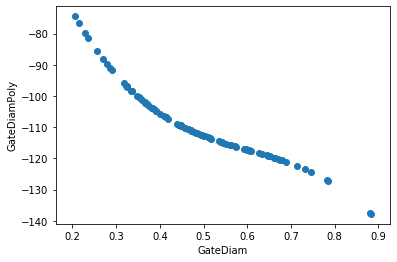

In [21]:
GateDiamPoly = X[['GateDiam','GateDiamSq','GateDiamCube']].dot(new_linear_model.params[['GateDiam','GateDiamSq','GateDiamCube']])
plt.scatter(df['GateDiam'],GateDiamPoly)
plt.xlabel('GateDiam')
plt.ylabel('GateDiamPoly')

Ans:
* Bachtime -- (GateDiam, decrease), (RiserDiam, increase), (RiserHeight, increase)
* Feasible -- (RiserDiam, increase), (SprueDiamBot, decrease), (SprueDiamTop, decrease), (RiserHeight, decrease)

## Question 7
Our goal is to set the mold-variables to minimize expected `BatchTime` and
maximize $P(Feasible = 1)$. We will constrain the value of each predictor to be between the minimum and maximum values in `castdata.csv`.

Based on your answers to the previous question, for each variable that affected one response variable but not the other, state its optimal value for increasing the probability of feasibility and decreasing batch time. For most (and perhaps all) predictors, the value will either be at the minimum or maximum of the values in `castdata.csv` for that predictor --- in these cases you can just say `min` or `max`.

Ans: 
* GateDiam, max
* SprueDiamBot, min
* SprueDiamTop, min

# Randomized Search for Better Operating Conditions

We now search to find values of the mold-variables that give a low expected `BatchTime` subject to the probability that the casting is feasible being at least 0.95. This problem is best solved by linear programming, but, since linear programming is not a prerequisite for this course, we will use a randomized search.

Now we create a new set called newdata with 1,000,000 rows where the predictors vary uniformly between their smallest and largest values in the original data. The responses `BatchTime` and `Feasible` are not included in this data set. Rather, the expected values of `BatchTime` and `Feasible` are predicted using the logistic model and the linear model, respectively.

In [22]:
upperbounds = df[predictors].max()
lowerbounds = df[predictors].min()
N = 1000000
np.random.seed(10) 
newdata = pd.DataFrame()
for i in range(9):
    newdata[df.columns[i]] = np.random.uniform(lowerbounds[i],upperbounds[i],N)

newdata = sm.add_constant(newdata)
newdata['GateDiamSq']=newdata['GateDiam']**2
newdata['GateDiamCube']=newdata['GateDiam']**3
newdata.head()

,const,GateDiam,CupHeight,SprueHeight,RiserDiam,SprueDiamBot,SprueDiamTop,RiserHeight,Riser1Pos,Riser2Pos,GateDiamSq,GateDiamCube
0,1.0,0.728633,4.782974,11.296558,7.497856,0.749386,1.049829,3.673499,2.972775,5.886284,0.530907,0.386836
1,1.0,0.219408,5.575331,11.519561,5.695499,0.646504,0.903803,4.094723,3.045477,5.443165,0.048140,0.010562
2,1.0,0.635229,4.803371,10.851808,7.542823,0.708284,1.077576,5.283172,3.675518,4.762267,0.403516,0.256325
3,1.0,0.713357,4.583025,10.377216,7.187206,0.534918,0.532767,4.861789,2.550009,5.292597,0.508878,0.363011
4,1.0,0.543542,4.154392,9.184616,6.733361,0.731484,0.352599,4.012132,2.574189,5.855998,0.295438,0.160583


Next, use `model.predict()` to compute the probability that `Feasible` is equal to 1, and create a sub-dataset called `newdata_feas` of `newdata` where this probability exceeds 0.95. 

Note: be careful when using `.predict()` for classification problems. Depending on the package it will give the probability of the outcome being 1 or a prediction (0 or 1). For example when using sklearn.LogisiticRegression, `.predict()` gives a 0-1 prediction and `.predict_prob()` gives the probability of the outcome being 1.

In [24]:
#predict probability of feasible block for each data point and remove points 
#with probability less than 0.95
Yhat = new_model.predict(newdata[logit_variables])
newdata_feas = newdata[pd.Series(Yhat >= 0.95)]

Now, predict the value of `BatchTime` for all rows of newdata_feas and find the row where `BatchTime` is minimized; this is the single row of the dataset. 

In [37]:
exBatchTime = new_linear_model.predict(newdata_feas[linear_variables])
print(exBatchTime.min())

2979.1418288158625


## Question 9
What is the expected value of BatchTime under optimal conditions? “Optimal
conditions” means that the predictors are set to the best feasible values in newdata.

Ans: 2979.14 seconds

To help you answer the next question, here are the minimum and maximum value of each predictor.

In [28]:
df[predictors].min()

GateDiam        0.205329
CupHeight       3.947455
SprueHeight     8.848969
RiserDiam       5.417082
SprueDiamBot    0.256138
SprueDiamTop    0.321120
RiserHeight     3.399719
Riser1Pos       2.535606
Riser2Pos       3.629352
dtype: float64

In [29]:
df[predictors].max()

GateDiam         0.883781
CupHeight        5.999328
SprueHeight     11.877841
RiserDiam        8.303038
SprueDiamBot     0.849809
SprueDiamTop     1.231756
RiserHeight      5.978733
Riser1Pos        4.387350
Riser2Pos        6.010920
dtype: float64

## Question 10
What are the “optimal” values of the variables, where “optimal” means minimizing the expected `BatchTime` subject to $P(Feasible = 1) > 0.95$. Compare these results with your answer to Question 7 and say whether your results are consistent. You may also want to output the maximum and minimum values for each variable using the code `df.max()` and `df.min()`

Ans: These answers are partially consistant -- the 'optimal' GateDiam value is the max

In [52]:
#your code here
print(newdata_feas.iloc[np.argmin(exBatchTime)])

const            1.000000
GateDiam         0.846901
CupHeight        4.644741
SprueHeight     10.849084
RiserDiam        8.032133
SprueDiamBot     0.710432
SprueDiamTop     0.881679
RiserHeight      4.453623
Riser1Pos        3.619079
Riser2Pos        5.209221
GateDiamSq       0.717242
GateDiamCube     0.607433
Name: 955082, dtype: float64


## Question 11

What is the probability that Feasible will equal 1 under optimal conditions?
Hint: Use predict again.


Ans:

In [45]:
new_model.predict(newdata_feas.iloc[np.argmin(exBatchTime)][logit_variables].values)

array([0.95939371])

~96% probability